In [3]:
import numpy as np
import pandas as pd
import pvlib

latitude, longitude = 41.41874465534282, 2.211007211467843
tz = "Europe/Madrid"

# Set times in the morning of the December solstice.
times = pd.date_range(
    '2024-01-01 00:00', '2024-12-31 23:59', freq='1h', tz=tz
)

# Create location object, and get solar position and clearsky irradiance data.
location = pvlib.location.Location(latitude, longitude, tz)
solar_position = location.get_solarposition(times)
clearsky = location.get_clearsky(times)

# Assign variable names for easier reading.
surface_tilt = 23
surface_azimuth = 164
solar_azimuth = solar_position.azimuth
solar_zenith = solar_position.apparent_zenith
solar_elevation = solar_position.apparent_elevation
dni = clearsky.dni
ghi = clearsky.ghi
dhi = clearsky.dhi

Text(0, 0.5, 'Horizon angle [°]')

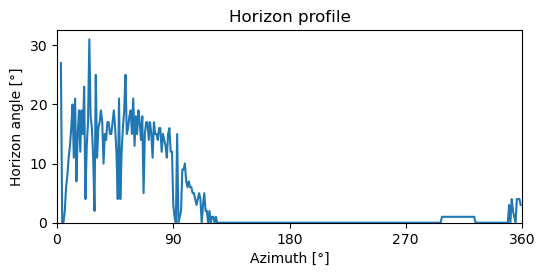

In [4]:
planeFile = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Results/Test_70_el Besòs i el Maresme/Parcels/4157903DF3845E/86/Shading/13.csv"
shadingProfilesDF = pd.read_csv(planeFile, header=None)
tilts = shadingProfilesDF.iloc[0][3:363]

# Use hard-coded horizon profile data from location object above.
horizon_profile = pd.Series(tilts, index=np.arange(0, 360, 1))

ax = horizon_profile.plot(xlim=(0, 360), ylim=(0, None), figsize=(6, 2.5))
ax.set_title('Horizon profile')
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xlabel('Azimuth [°]')
ax.set_ylabel('Horizon angle [°]')

In [5]:
# Interpolate the horizon elevation data to the solar azimuth, and keep as a
# numpy array.
horizon_elevation_data = np.interp(
    solar_azimuth, horizon_profile.index, horizon_profile
)

# Convert to Pandas Series for easier usage.
horizon_elevation_data = pd.Series(horizon_elevation_data, times)

# Adjust DNI based on data - note this is returned as numpy array
dni_adjusted = np.where(solar_elevation > horizon_elevation_data, dni, 0)

# Adjust GHI and set it to DHI for time-periods where 'dni_adjusted' is 0.
# Note this is returned as numpy array
ghi_adjusted = np.where(dni_adjusted == 0, dhi, ghi)

# Transposition using the original and adjusted irradiance components.
irrad_pre_adj = pvlib.irradiance.get_total_irradiance(
    surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi
)

irrad_post_adj = pvlib.irradiance.get_total_irradiance(
    surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni_adjusted,
    ghi_adjusted, dhi
)

# Create and plot result DataFrames.
poa_global_comparison = pd.DataFrame({
    'poa_global_pre-adjustment': irrad_pre_adj.poa_global,
    'poa_global_post-adjustment': irrad_post_adj.poa_global
})

dni_comparison = pd.DataFrame({
    'dni_pre-adjustment': dni,
    'dni_post-adjustment': dni_adjusted
})

<Axes: title={'center': 'DNI: Before and after Horizon Adjustment'}, ylabel='Irradiance'>

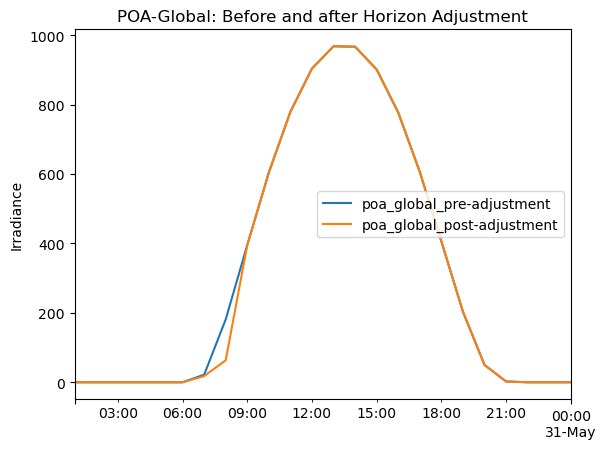

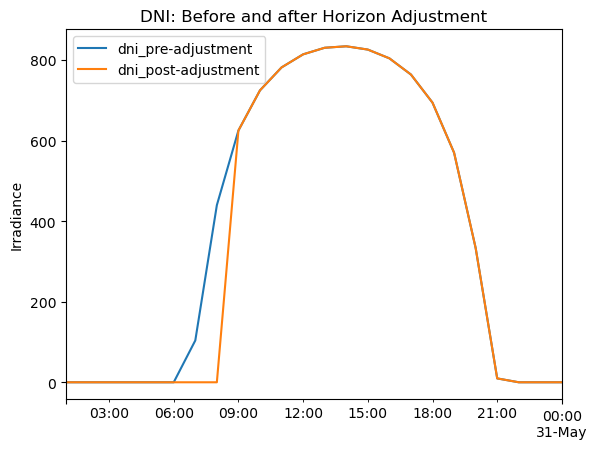

In [6]:
# Plot results
poa_global_comparison[24*150+0:24*150+24].plot(
    title='POA-Global: Before and after Horizon Adjustment',
    ylabel='Irradiance'
)
dni_comparison[24*150+0:24*150+24].plot(
    title='DNI: Before and after Horizon Adjustment', ylabel='Irradiance'
)

In [7]:
cec_modules = pvlib.pvsystem.retrieve_sam(
    path="/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/RAW_Data/Modules and Invertes/CEC Modules.csv"
)
cec_inverters = pvlib.pvsystem.retrieve_sam(
    path="/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/RAW_Data/Modules and Invertes/CEC Inverters.csv"
)

/home/jaumeasensio/anaconda3/envs/qgis_stable/lib/python3.12/site-packages/pvlib/pvsystem.py:2094: UserWarning: Original names contain 505 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
/home/jaumeasensio/anaconda3/envs/qgis_stable/lib/python3.12/site-packages/pvlib/pvsystem.py:2098: UserWarning: Normalized names contain 505 duplicate(s).
  warnings.warn(


In [8]:
module = cec_modules["SunPower_SPR_MAX3_400"]
module_width = 1.69
module_length = 1.05
inverter = cec_inverters["SunPower__SPR_A400_H_AC__240V_"]

In [9]:
module_area = module_width * module_length
max_panels_manual = round(40/module_area)
max_panels_manual

23

In [12]:
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain

# Define PV system characteristics
system = PVSystem(
        surface_tilt=23,
        surface_azimuth=164,
        module_parameters=module,
        inverter_parameters=inverter,
        temperature_model_parameters=temperature_model_parameters,
    )

NameError: name 'temperature_model_parameters' is not defined